In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from initialize_model import *
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from model import *
from functions.stylizedfacts import autocorrelation_returns
from matplotlib import style
from functions.indirect_calibration import quadratic_loss_function
import scipy.stats as stats
from SALib.sample import latin
from hurst import compute_Hc

In [2]:
style.use('seaborn-ticks')

# Run the model

First insert calibrated parameters.

In [3]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price']))
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]

In [4]:
params = {"trader_sample_size": 10, # selected for comp efficiency
          "n_traders": 1000, # selected for comp efficiency
          "init_stocks": int((21780000000 / 267.33) / float(1000000)), # market valuation of Vanguard S&P 500 / share price 
          "ticks": len(p), # lenght of reference data
          "fundamental_value": p.mean(), # average value of reference data, assuming efficient markets
          "std_fundamental": p_returns.std(), # standard deviation of returns sp price, assuming efficient markets
          "base_risk_aversion": 0.7, # estimate from Kim & Lee (2012)
          'spread_max': 0.004087, # estimate from Riordan & Storkenmaier (2012)
          "horizon": int(len(p) * 0.35), # estimate based on average churn ratio found by Cella, Ellul and Giannetti (2013)
          # estimated parameters
          "std_noise": 0.01, 
          "w_random": 1.0, 
          "strat_share_chartists": 0.0,
          # parameter only used for experiment
          "mean_reversion": 0.0,
          # fixed / not modelled parameters
          "fundamentalist_horizon_multiplier": 1.0,
          "mutation_intensity": 0.0,
          "average_learning_ability": 0.0,
          "trades_per_tick": 1
         }

Next, add estimated parameters from json file. 

In [5]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [6]:
for i, name in enumerate(['std_noise', "w_random", "strat_share_chartists"]):
    params[name] = est_params[i]

# Run model

First determine the amount of simulation runs. At every run a different random seed will be used.

In [7]:
NRUNS = 2

All the data output data of the model will be stored in a list of traders and list of orderbooks per seed. 

In [8]:
trdrs0 = []
orbs0 = []
for seed in range(NRUNS): 
    traders0, orderbook0 = init_objects(params, seed)
    traders0, orderbook0 = ABM_model(traders0, orderbook0, params, seed)
    trdrs0.append(traders0)
    orbs0.append(orderbook0)

Start of simulation  0
Start of simulation  1


Store the data in dataframes

In [9]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs0, burn_in_period=0)

# Model generated price & volume

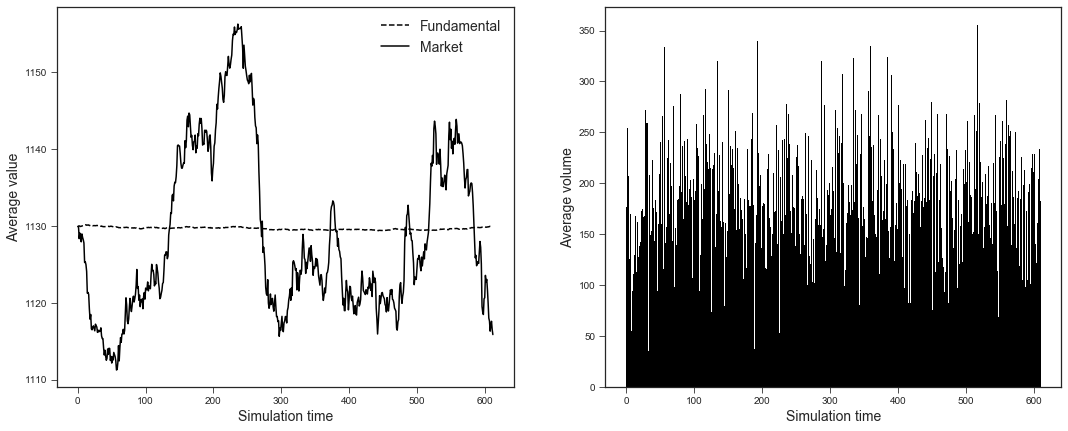

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='Fundamental')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k', label='Market')
ax1.legend(loc='best', fontsize='14')

ax1.set_ylabel('Average value', fontsize='14')

ax2.bar(mc_volume.index, mc_volume.mean(axis=1), width=1.0, color='black')
ax2.set_ylabel('Average volume', fontsize='14')

for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='14')
    

#fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Model generated returns per agent

In [13]:
wealth_starts = []
wealth_ends = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs0):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs0[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs0[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs0[seed].tick_close_price[-1] - orbs0[seed].tick_close_price[0]) / orbs0[seed].tick_close_price[0] for x in range(len(wealth_start))])

    for t in range(params['ticks']):
        #print(t)
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs0[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))

In [14]:
av_profits = np.zeros(len(profits[0]))

for i in range(len(profits)):
    av_profits += profits[i]
    
av_profits = av_profits / float(len(profits))

The graph below depicts returns of individual agents. Ideally the RL agent will at some point in time outperform all other agents.

Text(0.5, 0, 'Agent number')

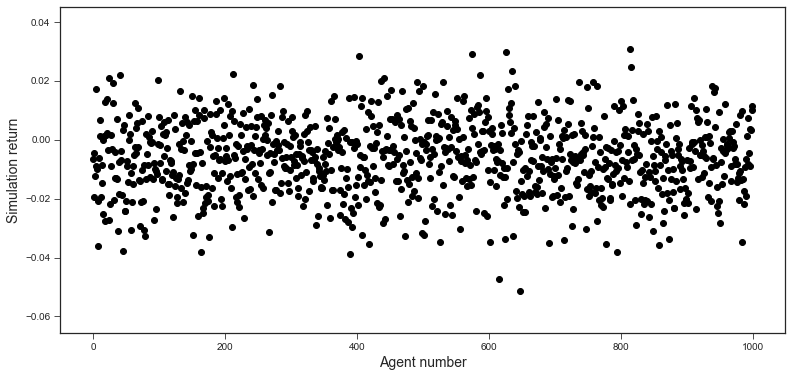

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(13,6))

ax1.scatter(range(len(av_profits)), av_profits, color='black')

ax1.set_ylabel('Simulation return', fontsize='14')

ax1.set_xlabel('Agent number', fontsize='14')